In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.tform import tform
#from meshmaker.field import scalar_field, vec3_field
from meshmaker.mesh import planargraph, trimesh
from meshmaker.geometry import slide, sintsxyp, bbox, subdivide_triangles, loop_normal, loop_exterior, loop_split, loop_smooth, loop_contract, loop_area, periodic, isnear
from meshmaker.lsystem import lsystem
from meshmaker.img import perlin, proximal, normalize, segment_regions, steepness
from meshmaker.plt import plot, plot_pg, plot_loop, plot_edges, plot_edge, plot_point
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from functools import partial, reduce

In [3]:
import cv2


class field:
    """"""

    @staticmethod
    def decay(decay, weight):
        return lambda o, r: o * (weight * np.exp(-decay * r ** 2))
    

    @staticmethod
    def zero():
        raise NotImplementedError


    def __new__(cls, methods):
        def f(p):
            q = cls.zero()
            for m in methods:
                q = q + m(p)
            return q
        return f


class scalar_field(field):
    """"""

    @classmethod
    def zero(cls):
        return 0.0


    @classmethod
    def radial(cls, q, z, decay=0.0, weight=1.0):
        decay = cls.decay(decay, weight)
        def eigen(p):
            return decay(z, p.dxy(q))
        return eigen

    
    @classmethod
    def edge(cls, u, v, z, decay, weight):
        decay = cls.decay(decay, weight)
        def eigen(p):
            return decay(z, p.dexy(u, v))
        return eigen
    
    
    @classmethod
    def loop(cls, loop, z, decay, weight):
        loop = [cls.edge(u, v, z, decay, weight) for u, v in slide(loop, 2)]
        return cls(loop)

    
    @classmethod
    def topography(cls, img, tf, weight):        
        def eigen(p):            
            local = tf.transform(p)
            x = min(img.shape[1] - 1, int(local.x))
            y = min(img.shape[0] - 1, int(local.y))
            z = img[y, x]
            return z * weight
        return eigen


class image_field(scalar_field):
    """"""

    def __new__(cls, tf, img):
        es = (scalar_field.topography(img, tf, 1.0), )
        fd = super().__new__(cls, es)
        fd.img = img
        fd.tf = tf
        return fd


class height_field(image_field):
    """"""
    
    def __new__(cls, origin, radius, resolution, landmasses, dz=1):
        pixels = int(2 * radius * resolution)
        tf = cls.wtoi(origin, radius, pixels)
        n = perlin(pixels, 16 * 8, 8, 4)    
        f = lambda d: max(0, d) ** 0.8
        p = [proximal(pixels, tf.transform(lm), f) for lm in landmasses]
        p = sum(p)
        p = normalize(p)
        height = n * p * dz
        #for j in range(2):
        #    height = cv2.blur(height, (8, 8))
        return super().__new__(cls, tf, height)

    @staticmethod
    def wtoi(origin, radius, resolution):
        dp = origin.tov(vec3(resolution / 2, resolution / 2, 0))
        ds = vec3(resolution / (2 * radius), resolution / (2 * radius), 1)
        tf = tform(dp, None, ds)
        return tf


class vec3_field(field):
    """"""

    @staticmethod
    def zero():
        return vec3.O()


    @classmethod
    def radial(cls, q, decay, weight):
        decay = cls.decay(decay, weight)
        def eigen(p):
            return decay((p - q).nrm(), p.dxy(q))
        return eigen

    
    @classmethod
    def grid(cls, q, major, decay, weight):
        decay = cls.decay(decay, weight)
        def eigen(p):
            return decay(major, p.dxy(q))
        return eigen

    
    @classmethod
    def edge(cls, u, v, decay, weight):
        decay = cls.decay(decay, weight)
        tangent = (v - u).nrm()
        normal = tangent.crs(vec3.Z()).nrm()
        def eigen(p):
            isleft = ((u.x - p.x) * (v.y - p.y) - (v.x - p.x) * (u.y - p.y))
            return decay(normal * (1 if isleft else -1), p.dexy(u, v))
            #return decay(tangent, p.dexy(u, v)) 
        return eigen


    @classmethod
    def loop(cls, loop, decay, weight):
        loop = [cls.edge(u, v, decay, weight) for u, v in slide(loop, 2)]
        return cls(loop)

    
    @classmethod
    def topography(cls, terrain, weight):
        dx, dy = np.gradient(terrain.img)
        dx = image_field(terrain.tf, dx)
        dy = image_field(terrain.tf, dy)
        def eigen(p):
            dpdx = dx(p)
            dpdy = dy(p)
            return vec3(dpdx, dpdy, 0) * weight * max(1, np.sqrt(dpdx ** 2 + dpdy ** 2))
        return eigen


class trace_field(vec3_field):
    """"""
    
    def __new__(cls, methods, ds=1, alpha=0):
        fd = super().__new__(cls, methods)
        def f(p):
            """trace a sequence of new edges using fields"""
            while True:
                q = p + (fd(p).nrm() * ds).rot(quat.av(alpha, vec3.Z()))
                yield q
                p = q
        return f

In [26]:
from meshmaker.geometry import loop_contains

class loop_tree:
    
    @classmethod
    def bloops(cls, b, loops):
        t = cls(b)
        for l in loops:
            t.av(l)
        return t
    
    @property
    def depth(self):
        d = 0
        p = self.parent
        while p is not None:
            d += 1
            p = p.parent
        return d
    
    def __init__(self, loop, parent=None, **kws):
        self.loop = loop
        self.parent = parent
        self.children = []
        if self.parent is not None:
            self.parent.children.append(self)
        for key, value in kws.items():
            setattr(self, key, value)
                
    def av(self, loop, **kws):
        if loop_contains(self.loop, loop):
            for c in self.children:
                nv = c.av(loop, **kws)
                if nv is not None:
                    return nv
            else:
                return loop_tree(loop, self, **kws)

    def plot(self, ax, depth=2):
        
        linewidth = (self.depth + 1) * 2
        color = 'k' if self.depth % 2 == 0 else 'b'
        plot_loop(ax, self.loop, lw=linewidth, col=color, mk='')
        for c in self.children:
            c.plot(ax, depth + 2)

In [4]:
def plot_vec3_field(ax, fd):
    ps = []
    for x in np.linspace(-500, 500, 21):
        for y in np.linspace(-500, 500, 21):
            ps.append(vec3(x, y, 0))
    a, b = bbox(ps)
    dl = max(b.x - a.x, b.y - a.y) / 100
    for p in ps:
        v = fd(p)
        v.nrmd()
        u = v.crs(vec3.Z())
        u.nrmd()
        plot_point(ax, p)
        plot_edge(ax, p - v * (dl / 1), p + v * (dl / 1), lw=2, col='b')
        plot_edge(ax, p - u * (dl / 1), p + u * (dl / 1), lw=1, col='g')
    _ = 300
    ax.set_xlim((-_, _))
    ax.set_ylim((-_, _))
    return ax

In [5]:
def percentile_mask(a, n=5):
    """set all but the n highest values in a to 0"""
    q = n * 100 / len(a)
    q = min(max(q, 100), 0)
    a[np.where(a < np.percentile(a, q))] = 0
    return a


def distribution(a, n_best=None):
    """get a useful distribution for sampling from a"""
    if n_best is not None:
        a = percentile_mask(a, n=n_best)
    if a.max() == 0:
        a += 1.0
    a /= a.sum()
    return a

In [27]:
class proceduralgraph(planargraph):    
    """a planar graph which can be procedural grown"""

    def __init__(self, fd, *ags, layer=0, **kws):
        super().__init__(*ags, **kws)
        self.fd = fd
        self.layer = layer
    

    @property
    def elements(self):
        """get vec3_field elements which may depend on self"""
        return [self.fd]

    
    def fork_field(self, decay=0.01, weight=1.0, min_order=4):
        """get scalar_field based on vertex path distances to forked intersections"""
        rad = partial(scalar_field.radial, decay=decay, weight=weight)
        es = ((v, self.forkorder(i)) for i, v in enumerate(self.vertices) if v is not None)
        return scalar_field([rad(v, o) for v, o in es if o >= min_order])
        
    
    def get_vertex_weights(self, fd, n_best=None, mask=None):
        """get a probability distribution over self.vertices for selection"""
        remask = lambda v: v is None or (mask is not None and mask(v))
        weights = [(0.0 if remask(v) else fd(v)) for v in self.vertices]
        return distribution(np.array(weights), n_best=n_best)


    def get_vertex_alpha(self, eb, p):
        """select alpha value where field points most toward vec3.com(eb)"""
        f = vec3_field(self.elements)(p).nrm()
        c = vec3.com(eb)
        best = None
        chosen = 0
        for alpha in (x * (np.pi / 2) for x in range(4)):
            q = p + f.cp().rot(quat.av(alpha, vec3.Z()))
            d = q.dxy(c)
            if best is None or d < best:
                chosen = alpha
                best = d
        return chosen
    
    
    def find_exit(self, eb, decay=0.01, weight=1.0, min_order=4):
        """find optimal existing vertex on eb"""
        mask = (lambda p: not p.onbxy(eb, True))
        field = self.fork_field(decay, weight, min_order)
        weights = self.get_vertex_weights(field, n_best=5, mask=mask)
        return np.random.choice(len(weights), p=weights)
    

    def find_tip(self, eb=None, decay=0.01, weight=1.0, min_order=4):
        """find optimal existing vertex optional inside or on eb"""
        mask = None if eb is None else (lambda p: not p.inbxy(eb, True))
        field = self.fork_field(decay, weight, min_order)
        weights = self.get_vertex_weights(field, n_best=5, mask=mask)
        return np.random.choice(len(weights), p=weights)
    

    def fork_tips(self, eb=None):
        """yield a sequence of new tips suitable for tracing"""
        s = self.find_tip(eb=eb)
        edges = [((s, o) if (s < o) else (o, s)) for o in self.rings[s]]
        edges = [self.edges[self.edge_lookup[e]] for e in edges]
        alphas = [p.get('alpha', self.get_vertex_alpha(eb, self.vertices[i]) + np.pi / 2) for i, j, p in edges]
        if len(alphas) == 0:
            yield (s, 0)
        elif len(alphas) == 1:
            # TODO: assert alpha which does not force u-turn
            yield (s, alphas[0])
        elif len(alphas) == 2:
            a = abs(alphas[1] - alphas[0])
            if isnear(a, 0) or isnear(a, np.pi):
                b = periodic(0, 2 * np.pi, alphas[0] + np.random.choice((1, 3)) * (np.pi / 2))
                yield (s, b)
                if np.random.random() < 0.5:
                    yield (s, periodic(0, 2 * np.pi, b + np.pi))
            else:
                # TODO: assert alpha which does not force u-turn
                yield (s, np.random.choice(alphas))
        elif len(alphas) == 3:
            # TODO: assert alpha which does not force u-turn
            yield (s, sorted(alphas, key=lambda a: alphas.count(a))[0])
        else:
            print('too many alphas!', alphas)

    
    def trace(self, ds, n, u, alpha, eb=None, ibs=None):
        """trace a sequence of new edges using fields"""
        p = self.vertices[u]        
        for i, q in enumerate(trace_field(self.elements, ds, alpha)(p)):
            if eb is not None and not q.inbxy(eb, False):
                for x, y in slide(eb, 2):
                    ip = sintsxyp(self.vertices[u], q, x, y)
                    if ip is not None:
                        v = self.av(ip, e=(0.9 * ds), layer=self.layer)
                        if v == u:
                            self.vertices[v].trn(ip - self.vertices[v])
                            return v
                        elif v < len(self.vertices) - 1:
                            return -1
                        else:
                            self.ae(u, v, alpha=alpha, layer=self.layer)
                            return v
                else:
                    raise ValueError('should have found intersection!')
            if ibs is not None:
                for ib in ibs:
                    if q.inbxy(ib, True):
                        for x, y in slide(ib, 2):
                            ip = sintsxyp(self.vertices[u], q, x, y)
                            if ip is not None:
                                v = self.av(ip, e=(0.9 * ds), layer=self.layer)
                                if v == u:
                                    self.vertices[v].trn(ip - self.vertices[v])
                                    return v
                                elif v < len(self.vertices) - 1:
                                    return -2
                                else:
                                    self.ae(u, v, alpha=alpha, layer=self.layer)
                                    return v
                        else:
                            raise ValueError('should have found intersection!')
            v = self.av(q, e=(0.9 * ds), layer=self.layer)
            if v == u:
                return -3
            self.ae(u, v, alpha=alpha, layer=self.layer)
            if not v == len(self.vertices) - 1:
                return -4
            u = v
            if i == n - 1:
                break
        return u
    
        
    def inset(self, eb, ibs, dl, tips=None, max_steps=50, fork_prob=0.2, max_depth=3, depth=0):
        """recursively generate a denser graph within eb but outside of ibs"""
        n = 10
        ds = dl / n
        
        if tips is None:
            tips = [(self.av(vec3.com(eb)), np.random.choice(4) * (np.pi / 2))]
        else:
            tips = [(self.av(p.cp()), self.get_vertex_alpha(eb, p)) for p in tips]
        
        steps = 0
        with tqdm(total=max_steps, desc='insetting roads') as pbar:
            while tips and steps < max_steps:
                tip, alpha = tips.pop(0)
                newtip = self.trace(ds, n, tip, alpha, eb=eb, ibs=ibs)
                if newtip < 0:
                    #print('end trace: {}'.format(newtip))
                    pass
                else:
                    tips.append((newtip, alpha))
                if np.random.random() < fork_prob or not tips:
                    for newtip in self.fork_tips(eb=eb):
                        tips.append(newtip)
                steps += 1
                pbar.update(1)
        
        if depth < max_depth - 1:
            loops = [[self.vertices[u] for u in l] for l in self.loops()]
            eloop = loops.pop(loop_exterior(loops))        
            for iloop in loops:
                tip = self.find_exit(iloop)
                tips = [(tip, self.get_vertex_alpha(iloop, self.vertices[tip]))]
                self.layer += 1
                self.inset(iloop, ibs, tips, dl, max_steps, fork_prob, max_depth, depth + 1)
                self.layer -= 1  

insetting roads:  30%|███       | 6/20 [00:00<00:00, 58.05it/s]

generating river layer (dl: 117.5906668388739)


insetting roads: 100%|██████████| 20/20 [00:00<00:00, 29.59it/s]


generating terrain (pg.minlen: 11.221494554723785)
finding the fairway
finding the green
generating landmass road layer (dl: 117.5906668388739)


insetting roads:   4%|▍         | 2/50 [00:00<00:02, 17.02it/s]

generating county road layer (dl: 117.5906668388739)


insetting roads:  10%|█         | 5/50 [00:00<00:01, 29.94it/s]

generating county road layer (dl: 117.5906668388739)


insetting roads:  34%|███▍      | 17/50 [00:00<00:01, 21.81it/s]

too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]
too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]
too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]


insetting roads:  48%|████▊     | 24/50 [00:00<00:01, 25.47it/s]

too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]
too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]
too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]


insetting roads:  88%|████████▊ | 44/50 [00:01<00:00, 36.03it/s]

too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]
too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]
too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]


insetting roads:   0%|          | 0/50 [00:00<?, ?it/s]

too many alphas! [3.141592653589793, 1.5707963267948966, 4.71238898038469, 3.141592653589793]
generating county road layer (dl: 117.5906668388739)


insetting roads:  30%|███       | 15/50 [00:01<00:03, 10.03it/s]

too many alphas! [4.71238898038469, 4.71238898038469, 4.71238898038469, 4.71238898038469]


insetting roads:  48%|████▊     | 24/50 [00:01<00:01, 15.05it/s]

too many alphas! [4.71238898038469, 4.71238898038469, 4.71238898038469, 4.71238898038469]


insetting roads:  90%|█████████ | 45/50 [00:02<00:00, 27.45it/s]

too many alphas! [4.71238898038469, 4.71238898038469, 4.71238898038469, 4.71238898038469]


insetting roads:   4%|▍         | 1/25 [00:00<00:02,  9.19it/s]

generating landmass road layer (dl: 117.5906668388739)


insetting roads:   8%|▊         | 4/50 [00:00<00:01, 23.29it/s]

generating county road layer (dl: 117.5906668388739)


insetting roads:  84%|████████▍ | 42/50 [00:01<00:00, 39.35it/s]

too many alphas! [3.141592653589793, 3.141592653589793, 4.71238898038469, 0.0]


insetting roads:   0%|          | 0/50 [00:00<?, ?it/s]

too many alphas! [0.0, 4.71238898038469, 4.71238898038469, 3.141592653589793]
generating county road layer (dl: 117.5906668388739)


insetting roads: 100%|██████████| 50/50 [00:02<00:00, 18.77it/s]

no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass
no counties within landmass


<IPython.core.display.Javascript object>


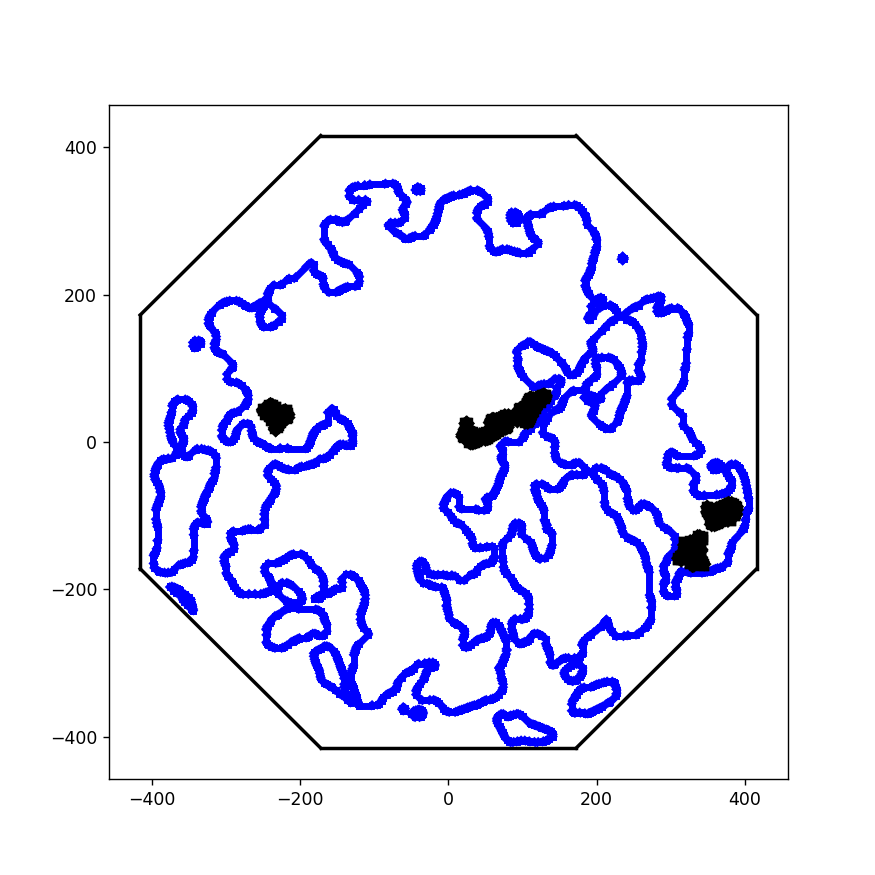

<IPython.core.display.Javascript object>


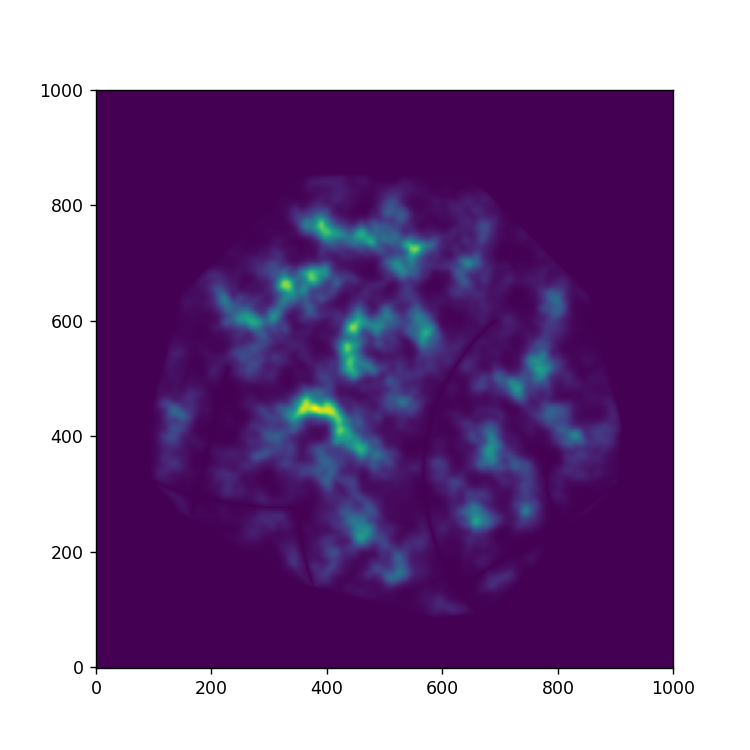

<IPython.core.display.Javascript object>


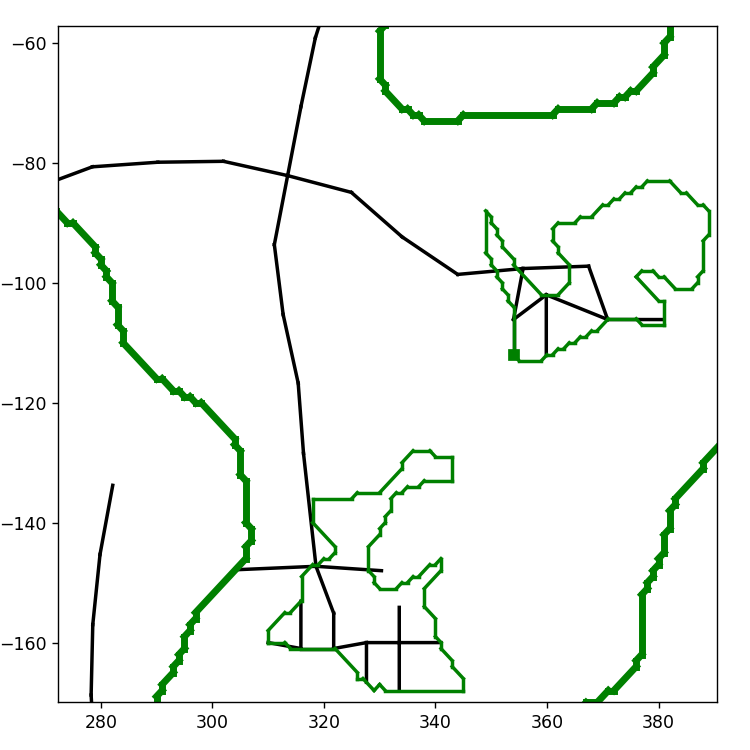

In [33]:
keeps = {}


def river_field(rim):
    n = len(rim) // 2
    ps = np.random.choice(rim, size=n)
    ds = np.random.randn(n) * 0.0001 + 0.001
    ws = np.ones(n)
    es = [vec3_field.radial(p, d, w) for p, d, w in zip(ps, ds, ws)]
    fd = vec3_field(es)
    return fd


def landmass_field(landmass, terrain):
    es = [
        vec3_field.grid(vec3.O(), vec3.X(), 0.0, 0.01),
        vec3_field.loop(landmass.loop, 0.1, 0.1),
        vec3_field.topography(terrain, 1.0),
    ]
    fd = vec3_field(es)
    return fd


def county_field(county, terrain):
    es = [
        vec3_field.grid(vec3.O(), vec3.Y(), 0.0, 0.1),
        vec3_field.topography(terrain, 0.1),
    ]
    for lake in county.children:
        assert lake.shore
        es.append(vec3_field.loop(lake.loop, 0.001, 0.1))
    fd = vec3_field(es)
    return fd


def test():
    seed = 0
    origin = vec3.O()
    radius = 500
    pixels_per_world_unit = 1
    sealevel = 0.04
    sandlevel = sealevel + 0.04
    n_cities = 5

    

    np.random.seed(seed)
    rim = origin.ring(radius - 50, 8)    
    pg = proceduralgraph(None, segs=slide(rim, 2))
    
    p, q = bbox(rim)
    dl = (q - p).mag() / 10
    print(f'generating river layer (dl: {dl})')
    tips = np.random.choice(rim, size=np.random.randint(2, len(rim) // 2))
    pg.fd = river_field(rim)
    pg.inset(rim, (), dl, tips=tips, max_steps=20, fork_prob=0.2, max_depth=1)


    print(f'generating terrain (pg.minlen: {pg.minlen(4)})')
    eloop, loops = pg.polygon()
    for i in range(1):
        loops = [loop_smooth(l, weight=0.5) for l in loops]
    terrain = height_field(origin, radius, pixels_per_world_unit, loops)
    itow = tform(vec3.U().xy() * -radius, None, vec3(2 * radius, 2 * radius, 0))

    print('finding the fairway')
    z0, dz = terrain.img.min(), terrain.img.max() - terrain.img.min()
    sealevel = z0 + sealevel * dz
    sandlevel = z0 + sandlevel * dz
    fps, lands, regions = segment_regions(terrain.img > sealevel)
    sealine = [itow.transform(fp) for fp in fps]

    print('finding the green')
    land = sum(lands)
    sand = land & (terrain.img < sandlevel)
    dirt = land & (terrain.img > sandlevel)
    grad = steepness(terrain.img * dirt)
    flat = dirt & (grad < np.percentile(grad[dirt > 0], 10))
    fps, flats, regions = segment_regions(flat)
    fps, flats, regions = zip(*sorted(zip(fps, flat, regions), key=lambda i: i[2].area)[-n_cities:])
    countyline = [itow.transform(fp) for fp in fps]

    lt = loop_tree(rim)
    for shore in sealine:
        nl = lt.av(shore, shore=True)
    for county in countyline:
        nl = lt.av(county, shore=False)

    for landmass in lt.children:
        counties = [c for c in landmass.children if not c.shore]
        if counties:
            lakes = [c.loop for c in landmass.children if c.shore]
            
            
            tips = [vec3.com(c.loop) for c in counties]
            
            
            print(f'generating landmass road layer (dl: {dl})')
            lmfd = landmass_field(landmass, terrain)
            pg.fd = lmfd
            pg.inset(landmass.loop, lakes, dl / 1.0, tips=tips,
                     max_steps=25, fork_prob=0.2, max_depth=1)
            
            for county in counties:

                
                tips = [county.loop[0].cp()]
                
                
                print(f'generating county road layer (dl: {dl})')
                pg.fd = county_field(county, terrain)
                pg.inset(county.loop, (), dl / 2.0, tips=tips,
                         max_steps=50, fork_prob=0.4, max_depth=1)

            else:
                pg.fd = lmfd
                
        else:
            print('no counties within landmass')
    
    
    
    keeps['rim'] = rim
    keeps['sealevel'] = sealevel
    keeps['sandlevel'] = sandlevel
    keeps['sealine'] = sealine
    keeps['countyline'] = countyline    
    keeps['terrain'] = terrain
    
    f, ax = plot(1, 1, figsize=(7, 7))
    lt.plot(ax)
    plt.show()
    
    f, ax = plot(figsize=(6, 6))
    ax.imshow(terrain.img, origin='lower')
    plt.show()

    f, ax = plot(figsize=(6, 6))
    f.tight_layout()
    
    #plot_vec3_field(ax, pg.fd)

    for i, v in enumerate(pg.vertices):
        if v is not None:
            v.properties['annotation'] = str(v.properties.get('layer'))

    plot_loop(ax, rim, col='r', lw=4, mk='o')
    plot_pg(ax, pg, mk='', lw=2, annotate=False)
    #for fw in loops:
    #    plot_loop(ax, fw, col='b', lw=2, mk='')
    for fw in keeps['sealine']:
        plot_loop(ax, fw, col='g', lw=4, mk='')
    for fw in keeps['countyline']:
        plot_loop(ax, fw, col='g', lw=2, mk='')
    if len(tips) > 0:
        for tip in tips:
            plot_point(ax, tip, mk='s', col='g')
    ax.set_xlim((-radius, radius))
    ax.set_ylim((-radius, radius))
    
    
#prun test(terrain)
test()

# #####

    pathing -> pick two points -> pick optimal point on midline between them -> repeat ad nauseum for subunits
    

In [29]:
from meshmaker.model import model


def worldly():
    origin, radius = vec3.O(), 500
    deltaz = radius / 4
    
    height = keeps['terrain']
    sealevel = keeps['sealevel']

    print(sealevel, deltaz, sealevel * deltaz)
    
    mesh = trimesh()
    
    triangles = origin.fan(radius, 6)
    for u, v, w in triangles:
        u = vec3(u.x, u.y, sealevel * deltaz)
        v = vec3(v.x, v.y, sealevel * deltaz)
        w = vec3(w.x, w.y, sealevel * deltaz)
        mesh.af(u, v, w)
    for i in range(6):
        triangles = subdivide_triangles(triangles)
    for u, v, w in triangles:
        u.set(u.x, u.y, height(u) * deltaz)
        v.set(v.x, v.y, height(v) * deltaz)
        w.set(w.x, w.y, height(w) * deltaz)
        mesh.af(u, v, w)
    
    models = (model().add(mesh, 'default'), )
    return models

In [30]:
from meshmaker.obj import obj_world


prefix = './'
models = worldly()
textures = {'default': './resources/textures/orangeboxtex.png'}
obj_world(prefix, models, textures)

0.011104134292606377 125.0 1.388016786575797
name model_2


# JUNK 

In [ ]:
from meshmaker.plt import plot, plot_pg, plot_loop


def loop_aggregate(loop, radius, alpha=None):
    assert len(loop) > 3, 'loops require 4+ vertices to aggregate'
    
    edges = [radius < (v - u).mag() for u, v in slide(loop, 2)]
    assert edges.count(True) > 2, 'nothing would be left after aggregate'
    
    piece = []
    newloop = []
    for u, v, w in slide(loop, 3):
        #print((v - u).mag(), (w - v).mag())
        if (v - u).mag() < radius or (w - v).mag() < radius:
            piece.append(v)
        elif alpha and (u - v).saxy(w - v) < alpha:
            piece.append(v)
        #else:
        if piece:
            newloop.append(vec3.com(piece))
            piece = []
        else:
            newloop.append(v)
    return newloop
    
def test():
    
    loop = vec3.O().ring(4, 32)
    reloop = loop_aggregate(loop, 4)
    
    f, ax = plot(figsize=(8, 8))
    plot_loop(ax, loop, col='g', lw=8)
    plot_loop(ax, reloop, col='b')
    
test()

In [ ]:
def loop_diagonals(loop):
    diagonals = {}
    for i in range(len(loop)):
        u = loop[i]
        for j in range(len(loop)):
            #if abs(i - j) > 1:
            if (i - j) > 1:
                v = loop[j]
                diagonals[(i, j)] = (u, v)
    return diagonals


def loop_diagonal_lengths(loop):
    diagonals = loop_diagonals(loop)
    lengths = [(v - u).mag() for u, v in diagonals.values()]
    return lengths